In [1]:
from typing import List

from hackerland.type_defs import Hackerland
from hackerland.generate_graph import (
    create_hackerland_fully_connected,
    create_hackerland_partially_connected,
)
from hackerland.evaluation import sum_pairs_of_unconnected_cities
from hackerland import plot



## Set up an original HackerLand, to be optimised. 

All cities are connected, including loops to themselves, and the weights for each road are randomly assigned. 

The optimisation process with remove the superfluous roads. 




This Hackerland has 0.0 unconnected pairs of cities.


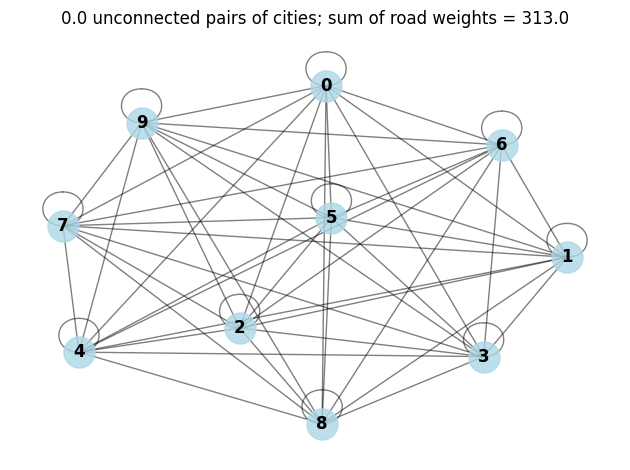

In [9]:

orig_hackerland: Hackerland = create_hackerland_fully_connected(n_cities=10)
n_unconnected_pairs = sum_pairs_of_unconnected_cities(
    hackerland=orig_hackerland, verbose=False
)
print(f"This Hackerland has {n_unconnected_pairs} unconnected pairs of cities.")

plot.plot_hackerland(orig_hackerland)


## Optimisation starts here

The UNSGA3 package is something I wrote many years ago when no implementation of this algorithm existed.
It's been ages since I used it (and my documentation should have been a LOT better).
It is a multi-objective optimisation algorithm.
Underpinning it is a genetic algorithm.
It attempts to find solutions that offer an optimal balance of

1) Number of unconnected pairs of cities and
2) The sum of road weights retained.

Though the original problem demanded all optimised cities be fully connected,
by allowing some flexibility in this you may allow paths through solution space that might otherwise be cut-off.

This next bit generates a LOT of text, scroll to the bottom...

In [10]:
import unsga3
from unsga3.unsga3 import Candidate
from hackerland.optimisation_utils import GenerationalInspector


def fitness_evaluator(population: List[Candidate], generation: int):
    # Evaluates a whole population of candidate solutions. 
    # Returns a list of fitnesses per candidate. 
    # Each fitness can be multiple items (also in a list) if there are multiple objectives. 
    # There are two objectives in the current problem formulation. 
    training_fitnesses = []
    validation_fitnesses = []  # This isn't used in this problem. Return None. 

    for candidate in population:
        train_fit, valid_fit = evaluate_candiate(candidate)
        training_fitnesses.append(train_fit)
        validation_fitnesses.append(valid_fit)

    return training_fitnesses, None  # Validation dataset fitnesses aren't used - return None. 


def evaluate_candiate(candidate: Candidate) -> float:
    # Evaluates a candidate solution. 
    # A candidate is a hackerland with some roads removed. 
    cand_hackerland = convert_candidate_to_hackerland(candidate)

    sum_of_road_weights = cand_hackerland.sum_weights()
    disconnected_city_pairs = sum_pairs_of_unconnected_cities(cand_hackerland)

    return [sum_of_road_weights, disconnected_city_pairs], None


def convert_candidate_to_hackerland(candidate: Candidate) -> Hackerland:
    cand_from_cities: List[int] = []
    cand_to_cities: List[int] = []
    cand_road_weights: List[float] = []
    cand_n_roads = 0
    for i, road_inclusion in enumerate(candidate.solution):
        if road_inclusion > 0.5:
            # Include the road
            cand_from_cities.append(orig_hackerland.from_cities[i])
            cand_to_cities.append(orig_hackerland.to_cities[i])
            cand_road_weights.append(orig_hackerland.road_weights[i])
            cand_n_roads += 1

    cand_hackerland = Hackerland(
        n_cities=orig_hackerland.n_cities,
        n_roads=cand_n_roads,
        from_cities=cand_from_cities,
        to_cities=cand_to_cities,
        road_weights=cand_road_weights,
    )
    return cand_hackerland


# Problem representation, one SolutionDimension per road that is either included or
# deleted from the final representation.
# Must be an immutable tuple (rather than a list)
# Roads having a value >0.5 will be included in a candidate solution to the problem. 
solution_dimensions = tuple(
    [
        unsga3.SolutionDimension(min_val=0.0, max_val=1.0, granularity=0.33)
        for road in range(orig_hackerland.n_roads)
    ]
)
num_objectives = 2
inspector = GenerationalInspector(attr="training_fitness")
op = unsga3.UNSGA3(
    solution_dimensions=solution_dimensions,
    fitness_evaluator=fitness_evaluator,
    num_objectives=num_objectives,
    max_generations=100,
    population_size=None,  # Auto-determine.
    reference_point_increments=5,
    generatonal_inspector_function=inspector.inspect,
)
op.run()

Number of reference points (or directions) to generate = 5
Population size not specified by user. Setting to 8, based on number of reference directions
entering generation 0
running generational inspection
  inspector: found 8 population candidates in generation 1
    cand: Candidate. Training: [122.0000   0.0000]; solution: [ 0.330  0.038  0.028  0.385  0.987  0.244  0.374  0.397  0.330  0.990  0.418  0.330  0.234  0.125  0.660  0.548  0.636  0.000  0.660  0.014  0.024  0.660  0.990  0.107  0.465  0.653  0.279  0.235  0.330  0.314  0.990  0.660  0.092  0.656  0.097  0.990  0.023  0.256  0.200  0.878  0.395  0.805  0.416  0.891  0.642  0.660  0.531  0.330  0.085  0.660  0.654  0.971  0.110  0.660  0.589]
    cand: Candidate. Training: [128.0000   0.0000]; solution: [ 0.373  0.330  0.000  0.291  0.268  0.823  0.142  0.990  0.218  0.990  0.409  0.330  0.684  0.660  0.684  0.022  0.123  0.000  0.660  0.260  0.000  0.775  0.990  0.483  0.351  0.316  0.371  0.214  0.439  0.816  0.680  0.660

(100,
 None)

### Evolution of solutions

This graph shows the best solutions across each generation of the genetic algorithm. 
Pink coloured solutions are the last generations (the best solutions). 
Performance is shown against two criteria, labelled in the graph. 
Where a generation does not offer any candidates improving over those aquired 
previously, that generation's solutions will be omitted from the graph. 



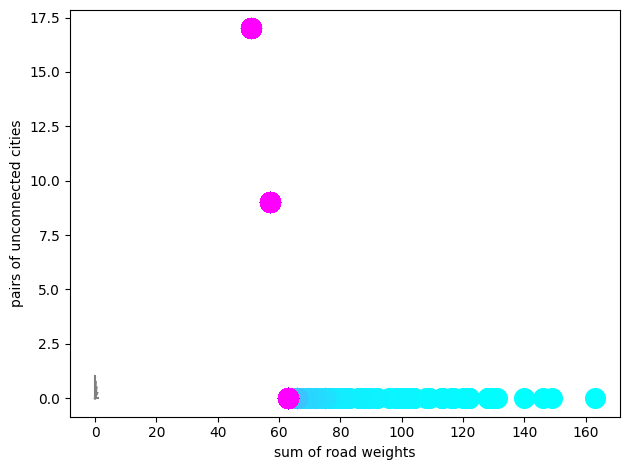

In [11]:

inspector.plot_all_generations_2d(
    xlabel="sum of road weights",
    ylabel="pairs of unconnected cities",
)

### Iterate through the best solutions found, graph them. 

Seems there's a few solutions that are equivalent. The optimisation process doesn't detect and exclude these.


This solution had no unconnected cities. Sum of road weights = 63.0


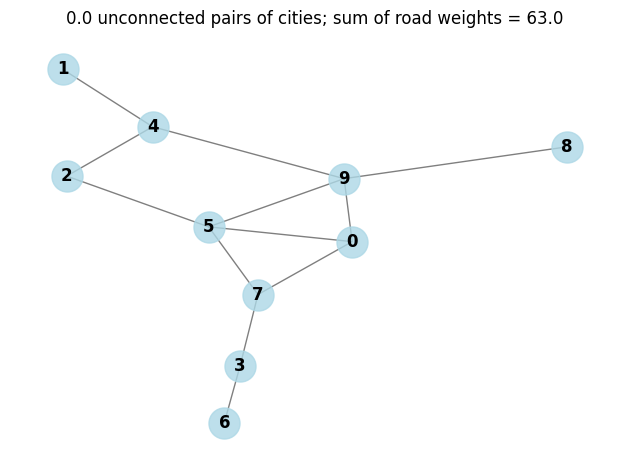

This solution had no unconnected cities. Sum of road weights = 63.0


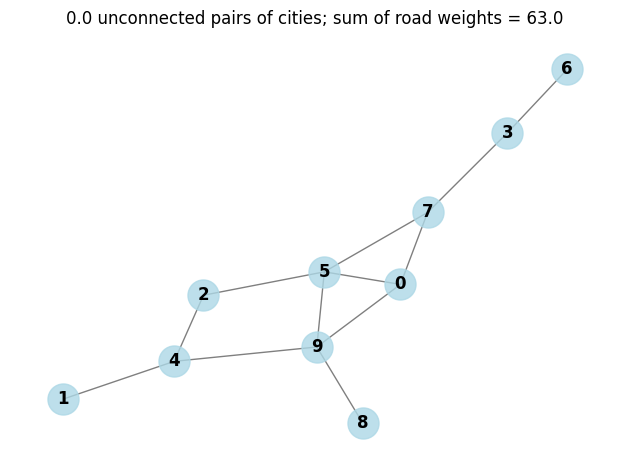

This solution had no unconnected cities. Sum of road weights = 63.0


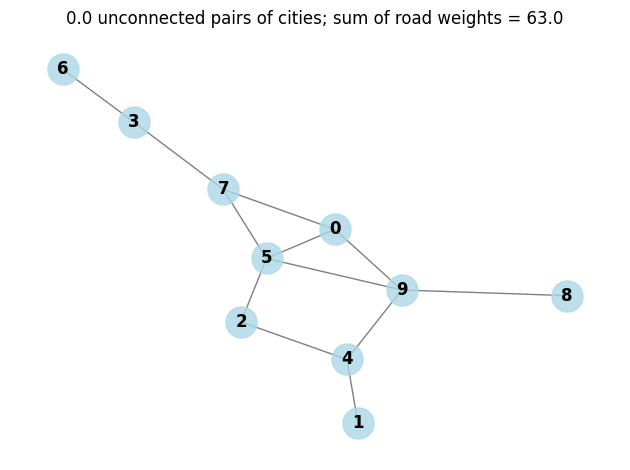

In [12]:

final_solutions: List[Candidate] = op.training_pareto_front
for cand in final_solutions:
    cand_pairs_unconnected_cities = cand.fitness[1]
    cand_sum_road_weights = cand.fitness[0]
    if cand_pairs_unconnected_cities == 0:
        print(
            f"This solution had no unconnected cities. "
            f"Sum of road weights = {cand_sum_road_weights}"
        )
        plot.plot_hackerland(convert_candidate_to_hackerland(cand))
